# Project Header

In this project, we are looking at actigraphy data sourced from the [Depresjon](https://datasets.simula.no/depresjon/) dataset with the goal of developing a classification algorithm to aid in non-invasive recognition of those with a Major Depressive Disorder. The study included 32 healthy and 23 afflicted participants and collected activity data through participant's continual wearing of a watch containing an accelerometer. A record exists for each minute over 13 or more days where the activity associated with each minute is the sum of the number of movements with an acceleration greater than .5g. Related literature includes:

* Enrique Garcia-Ceja, Michael Riegler, Petter Jakobsen, Jim Tørresen, Tine Nordgreen, Ketil J. Oedegaard, and Ole Bernt Fasmer. 2018. Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In Proceedings of the 9th ACM Multimedia Systems Conference (MMSys '18). Association for Computing Machinery, New York, NY, USA, 472–477. DOI:https://doi.org/10.1145/3204949.3208125

* Pacheco-Gonzalez, S.L., Zanella-Calzada, L.A., Galvan-Tejada, C.E., Chavez-Lamas, N.M., Rivera-Gomez, J.F., abnd Galvan-Tejada, J.I.. 2019. Evaluation of five classifiers for depression episodes detection, *Res. Comput. Sci.*, vol. 148, pp. 129-138.

* Rodríguez-Ruiz, J.G., Galván-Tejada, C.E., Vázquez-Reyes, S. et al. Classification of Depressive Episodes Using Nighttime Data; a Multivariate and Univariate Analysis. Program Comput Soft 46, 689–698 (2020). https://doi.org/10.1134/S0361768820080198

* Zanella-Calzada LA, Galván-Tejada CE, Chávez-Lamas NM, Gracia-Cortés MDC, Magallanes-Quintanar R, Celaya-Padilla JM, Galván-Tejada JI, Gamboa-Rosales H. Feature Extraction in Motor Activity Signal: Towards a Depression Episodes Detection in Unipolar and Bipolar Patients. Diagnostics (Basel). 2019 Jan 10;9(1):8. doi: https://10.3390/diagnostics9010008. PMID: 30634621; PMCID: PMC6468429.

# This Notebook

In this notebook we will examine and tune three types of models normally used in classification efforts: Random Forests, SVMs, and XGBoost.

## Importing Libraries and Processed Dataframe

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [3]:
all_grouped_dfs = pd.read_csv('./data/analysis_frame_all_subjects.csv', header = [0,1])

In [4]:
all_grouped_dfs.columns

MultiIndex([(        'activity',                 'sum'),
            (        'activity',              'median'),
            (        'activity',                'mean'),
            (        'activity',                 'max'),
            (        'activity',                 'std'),
            (        'activity',                 'var'),
            (        'activity',        'restful_mins'),
            (        'activity',       'zero_act_mins'),
            (         'resting',  'Unnamed: 8_level_1'),
            (           'night',  'Unnamed: 9_level_1'),
            (       'peak1_mag', 'Unnamed: 10_level_1'),
            (    'peak1_period', 'Unnamed: 11_level_1'),
            (       'peak2_mag', 'Unnamed: 12_level_1'),
            (    'peak2_period', 'Unnamed: 13_level_1'),
            (       'peak3_mag', 'Unnamed: 14_level_1'),
            (    'peak3_period', 'Unnamed: 15_level_1'),
            (       'condition', 'Unnamed: 16_level_1'),
            ('rest_interrupted'

In [5]:
all_grouped_dfs.columns = [(        'activity',                 'sum'),
            (        'activity',              'median'),
            (        'activity',                'mean'),
            (        'activity',                 'max'),
            (        'activity',                 'std'),
            (        'activity',                 'var'),
            (        'activity',        'restful_mins'),
            (        'activity',       'zero_act_mins'),
            (         'resting',  ''),
            (           'night',  ''),
            (       'peak1_mag', ''),
            (    'peak1_period', ''),
            (       'peak2_mag', ''),
            (    'peak2_period', ''),
            (       'peak3_mag', ''),
            (    'peak3_period', ''),
            (       'condition', ''),
            ('rest_interrupted', '')]

In [6]:
all_grouped_dfs.head()

,"(activity, sum)","(activity, median)","(activity, mean)","(activity, max)","(activity, std)","(activity, var)","(activity, restful_mins)","(activity, zero_act_mins)","(resting, )","(night, )","(peak1_mag, )","(peak1_period, )","(peak2_mag, )","(peak2_period, )","(peak3_mag, )","(peak3_period, )","(condition, )","(rest_interrupted, )"
0,9822,268.0,327.400000,1221,300.803934,90483.006897,2,2,0,0,1.837927e+06,24.2125,497278.8868,8.070833,391560.280231,19.37,1,0.0
1,10971,306.0,365.700000,783,214.970912,46212.493103,0,0,0,0,1.837927e+06,24.2125,497278.8868,8.070833,391560.280231,19.37,1,0.0
2,5514,181.0,183.800000,517,128.602676,16538.648276,1,1,0,0,1.837927e+06,24.2125,497278.8868,8.070833,391560.280231,19.37,1,0.0
3,11560,355.0,385.333333,948,271.096920,73493.540230,4,4,0,0,1.837927e+06,24.2125,497278.8868,8.070833,391560.280231,19.37,1,0.0
4,7206,129.5,240.200000,919,250.644328,62822.579310,2,2,0,0,1.837927e+06,24.2125,497278.8868,8.070833,391560.280231,19.37,1,0.0


In [53]:
all_grouped_dfs[('condition','')].value_counts()

0    33983
1    18378
Name: (condition, ), dtype: int64

In [7]:
target = all_grouped_dfs[('condition','')]
predictors = all_grouped_dfs.drop(columns = ('condition',''))

In [8]:
data_train, data_test, target_train, target_test = train_test_split(predictors, target, test_size = 0.3)

## Random Forest

### A Decision Tree Baseline

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10153
           1       1.00      1.00      1.00      5556

    accuracy                           1.00     15709
   macro avg       1.00      1.00      1.00     15709
weighted avg       1.00      1.00      1.00     15709



<AxesSubplot:>

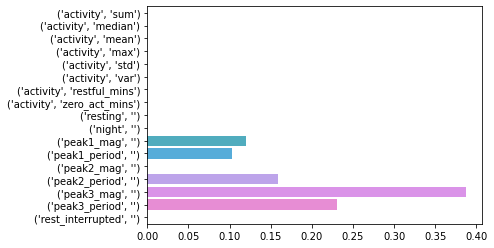

In [9]:
tree1 = DecisionTreeClassifier()
tree1.fit(data_train,target_train)
tree1_pred = tree1.predict(data_test)
print(classification_report(target_test,tree1_pred))
sns.barplot(x = tree1.feature_importances_, y = predictors.columns)

### Random Forests

In [10]:
forest1 = RandomForestClassifier()
forest1.fit(data_train,target_train)

RandomForestClassifier()

In [11]:
forest1.score(data_train,target_train)

1.0

In [12]:
forest1.score(data_test,target_test)

1.0

In [171]:
forest1.estimators_[0].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1446701602,
 'splitter': 'best'}

<AxesSubplot:>

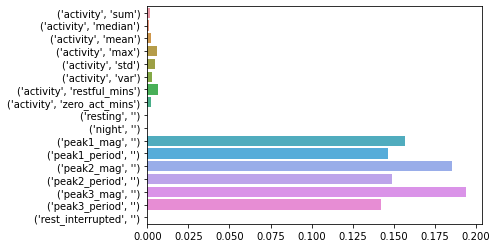

In [14]:
sns.barplot(x = forest1.feature_importances_, y = predictors.columns)

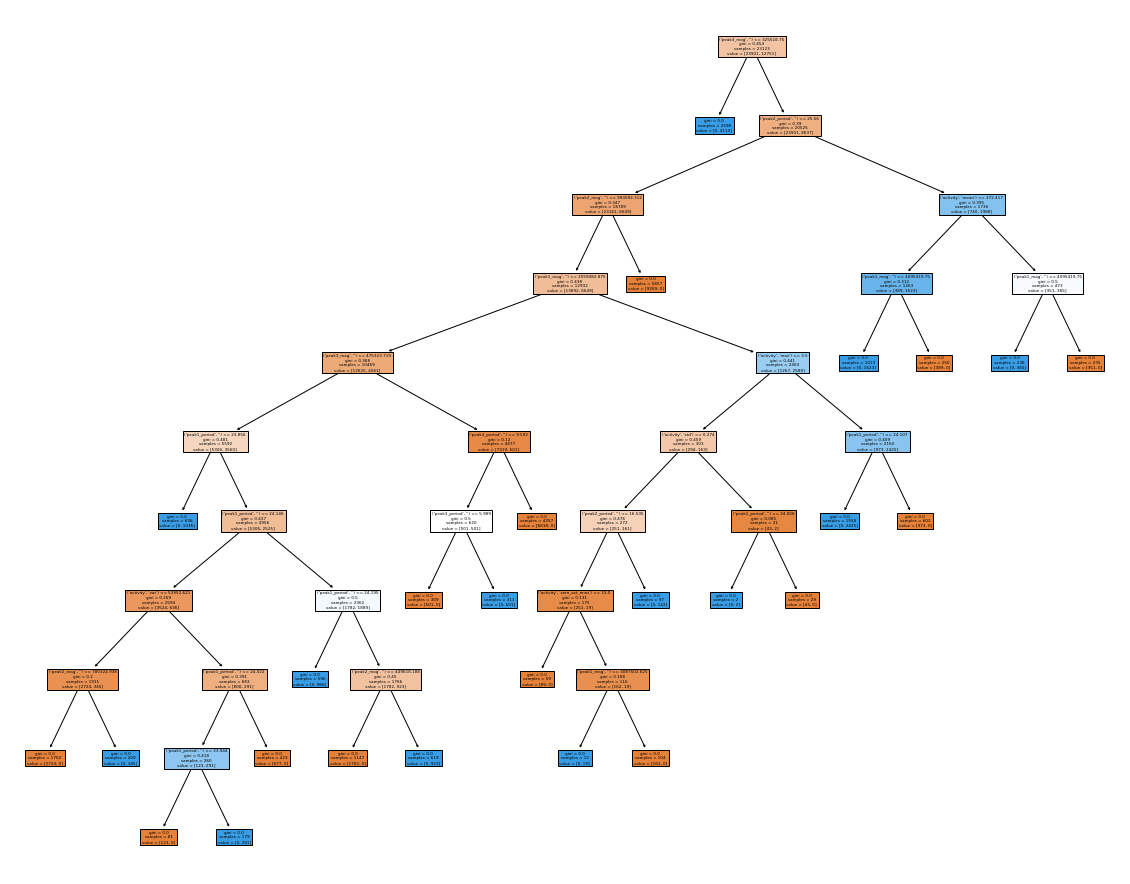

In [89]:
fig, ax = plt.subplots(figsize = (20,16))
tree.plot_tree(forest1.estimators_[0],feature_names = predictors.columns, filled = True);

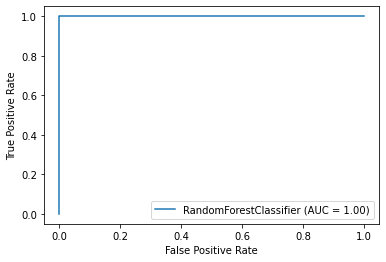

In [51]:
forest1_roc = plot_roc_curve(forest1, data_test, target_test)

## XGBoost

In [16]:
xgb1 = XGBClassifier()

In [17]:
xgb1.fit(data_train,target_train)
xgb1_preds = xgb1.predict(data_test)
print(accuracy_score(target_test,xgb1_preds))

1.0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

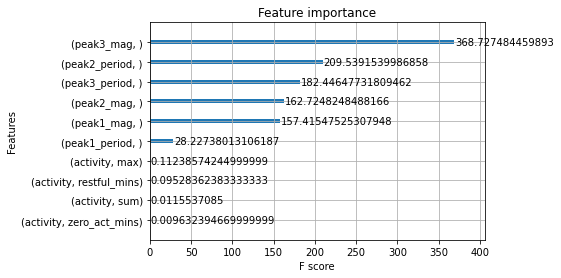

In [75]:
xgb.plot_importance(xgb1,importance_type = 'gain')

<AxesSubplot:>

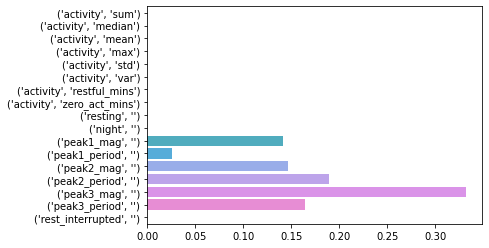

In [74]:
sns.barplot(x = xgb1.feature_importances_, y = predictors.columns)

<AxesSubplot:>

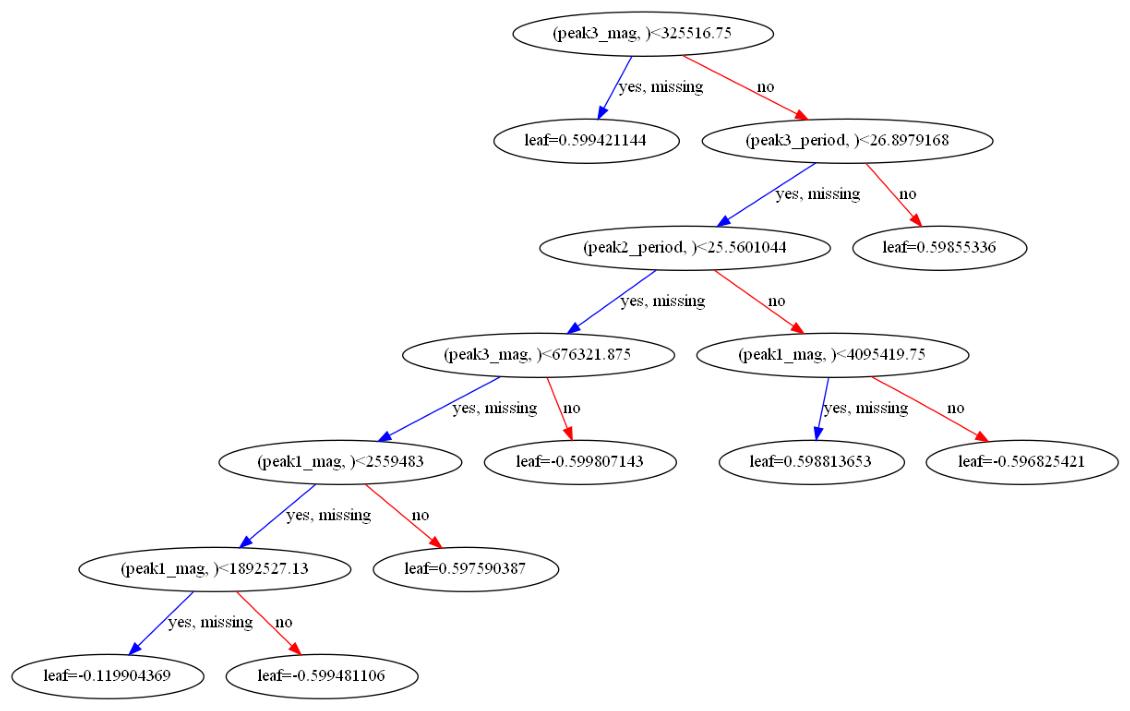

In [19]:
fig, ax = plt.subplots(figsize = (20,16))
xgb.plot_tree(xgb1,ax=ax)

## Trying out a pipeline

In [30]:
scaled_RF_pipe = Pipeline([('ss', StandardScaler()),
                           ('RF', RandomForestClassifier())])
scaled_XGB_pipe = Pipeline([('ss', StandardScaler()),
                           ('XGB', XGBClassifier())])

In [31]:
scaled_RF_pipe.fit(data_train,target_train)
scaled_XGB_pipe.fit(data_train,target_train)
print(scaled_RF_pipe.score(data_test,target_test))
print(scaled_XGB_pipe.score(data_test,target_test))

1.0
1.0


In [32]:
scaled_RF_pipe.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('RF', RandomForestClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'RF': RandomForestClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'RF__bootstrap': True,
 'RF__ccp_alpha': 0.0,
 'RF__class_weight': None,
 'RF__criterion': 'gini',
 'RF__max_depth': None,
 'RF__max_features': 'auto',
 'RF__max_leaf_nodes': None,
 'RF__max_samples': None,
 'RF__min_impurity_decrease': 0.0,
 'RF__min_impurity_split': None,
 'RF__min_samples_leaf': 1,
 'RF__min_samples_split': 2,
 'RF__min_weight_fraction_leaf': 0.0,
 'RF__n_estimators': 100,
 'RF__n_jobs': None,
 'RF__oob_score': False,
 'RF__random_state': None,
 'RF__verbose': 0,
 'RF__warm_start': False}

<AxesSubplot:>

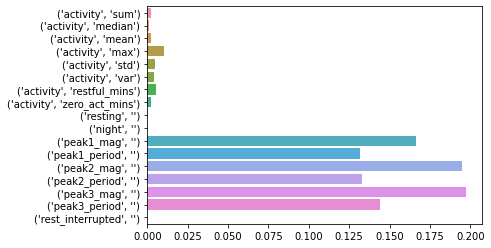

In [33]:
sns.barplot(x = scaled_RF_pipe.named_steps['RF'].feature_importances_, y = predictors.columns)

[Text(0, 0, "('activity', 'zero_act_mins')"),
 Text(0, 1, "('activity', 'sum')"),
 Text(0, 2, "('activity', 'restful_mins')"),
 Text(0, 3, "('activity', 'max')"),
 Text(0, 4, "('peak1_period', '')"),
 Text(0, 5, "('peak1_mag', '')"),
 Text(0, 6, "('peak2_mag', '')"),
 Text(0, 7, "('peak3_period', '')"),
 Text(0, 8, "('peak2_period', '')"),
 Text(0, 9, "('peak3_mag', '')")]

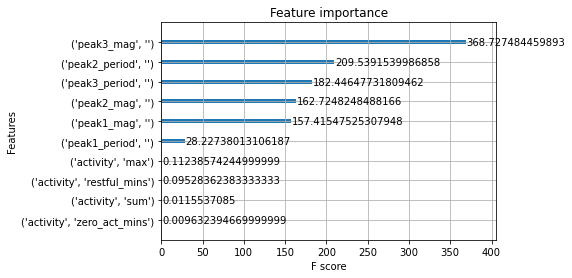

In [79]:
ax = xgb.plot_importance(scaled_XGB_pipe.named_steps['XGB'],importance_type = 'gain')
features = predictors.columns[[7,0,6,3,11,10,12,15,13,14]]
ax.set_yticklabels(features)

Not sure how plot importance gets it right with just XGBClassifier() and not through the pipleline, but have to do some finagling to get the y tick labels right with the pipeline.

## Trying Grid Search with a Random Forest for fun! 

Well, seeing as everything I try yields a one-hundred percent accuracy, let's see how low we can go with the hyperparameters and get it to still have 100%. This would in theory make it run faster as well.

In [227]:
forest2 = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [50, 40, 60 ],
    'max_depth': [ 9, 8, 10 ],
    'min_samples_split': [ 60  ],
    'min_samples_leaf': [ 30 ],
    'class_weight': ['balanced']
}

In [228]:
forest2_grid_search = GridSearchCV(forest2,rf_param_grid)

In [229]:
forest2_grid_search.fit(data_train,target_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'max_depth': [9, 8, 10],
                         'min_samples_leaf': [30], 'min_samples_split': [60],
                         'n_estimators': [50, 40, 60]})

In [230]:
forest2_grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 30,
 'min_samples_split': 60,
 'n_estimators': 50}

In [231]:
forest2_grid_search.score(data_test,target_test)

0.9998726844484054

<AxesSubplot:>

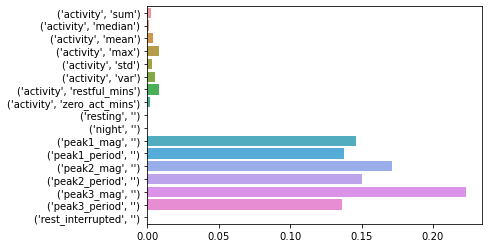

In [232]:
sns.barplot(x = forest2_grid_search.best_estimator_.feature_importances_, y = predictors.columns)

Based on messing around with the numbers in the grid manually, those are about the best I can do. It would seem to randomly score 1.0 exactly with similar sets of parameters, and also will sometimes return a score of less than 1 even if the grid isn't changed and a score of one was previously achieved. I also haven't lowered the params in the grid low enough to see a score worse than like .990 so it seems as if the classifiers are actually very solid at making predictions, and almost primarily based on the features defined in frequency space.